### Homework 4 - Seasonal ARIMA

The client believes that <u>seasonality</u> is an important component of estimating Ozone and is interested in the use of a seasonal ARIMA model.  The scope of services includes the following:

- The creation of a `seasonal ARIMA`.  Address how seasonality is incorporated into the model for Ozone and how this decision was made.
- Indicate if anything needs to be done for trend (if so, how was this addressed).
- Discuss any relevant information regarding autoregressive and/or moving average terms.
- Be sure to indicate if white noise is achieved for the recommended model and how this was determined.
- Show the actual versus predicted values in a time plot for the test data set (last 5 months) and provide a measure of accuracy for this test data.

Resources used:<br>
https://nwfsc-timeseries.github.io/atsa-labs/sec-tslab-autoregressive-moving-average-arma-models.html <br>
https://otexts.com/fpp2/non-seasonal-arima.html

In [2]:
# Import packages
library(readr) # read in data
library(tidyr) # data wrangling
library(dplyr) # data wrangling
library(ggplot2) # data visualization
library(ggthemes) # data visualization
library(tseries) # work with time series data
library(forecast) # forecast time series data
library(lmtest) # linear regression
library(zoo) # working with ts vectors/matrices
library(seasonal) # seasonal adjustment
library(lubridate) # working with dates
library(astsa) # ARIMA
library(repr) # change plot size in jupyter notebook

The following code rolls up provided daily data to monthly data. Data is then split into training, validation, testing data sets.

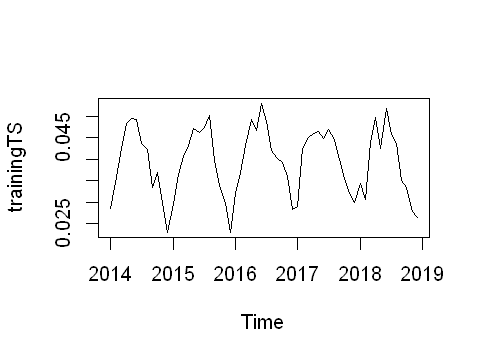

, , 1

                 [,1]
 [1,]  1.000000000000
 [2,]  0.701787011896
 [3,]  0.347247793763
 [4,] -0.028768165410
 [5,] -0.409456461139
 [6,] -0.616396331737
 [7,] -0.710628325089
 [8,] -0.593214025057
 [9,] -0.349725328389
[10,] -0.006828529493
[11,]  0.369692172963
[12,]  0.587770201534
[13,]  0.643695071049
[14,]  0.542901745777
[15,]  0.278456340869
[16,] -0.029820633833
[17,] -0.309107552813
[18,] -0.491267497280
[19,] -0.562649891844
[20,] -0.508619867958
[21,] -0.275402214562

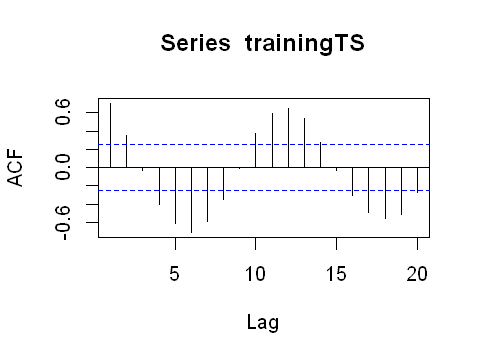

In [3]:
# import data and convert Date column from character to date 
data <- read_csv('C:/Users/chely/Documents/Time Series and Forecasting/Class Data/Ozone_Raleigh2.csv', 
                 col_types = cols(Date = col_date(format = '%m/%d/%Y')))

# Change Daily Max column name so it is shorter and easier to handle
names(data)[5] <- "maxOzoneC"

# Create a time plot of the mean monthly max 8 hour ozone concentration and upload it.
monthly_data <- data %>%
  mutate(month = month(Date)) %>%
  mutate(year = year(Date)) %>%
  group_by(year, month) %>%
  summarise(mean_ozone = mean(maxOzoneC, na.rm = T))

# Create monthly ts object
monthly_ts <- ts(monthly_data$mean_ozone, start = c(2014, 1), end = c(2020, 5), frequency = 12)

# Training data:
trainingTS <- subset(monthly_ts, end = length(monthly_ts) - 17)

# Validation data:
validTS <- subset(monthly_ts, start = length(monthly_ts) - 16, end = length(monthly_ts) - 5)

# Test data
testTS <- subset(monthly_ts, start = length(monthly_ts) - 4)


# Print out 10 decimal places
options(digits=10)

# Change plot size output in jupyter notebook
options(repr.plot.width=4, repr.plot.height=3)

# Visualize data to see what you have-- definitely seasonality!
plot(trainingTS)

Acf(trainingTS, lag = 20)$acf # seasonal pattern apparent

There is not a "best" formal test for determining seasonality so we need to carefully evaluate the time plot. The plot above clearly shows seasonality. Thus, we need to take care of its functional form first (before considering trend or autocorrelation). We have to address seasonality FIRST because oftentimes a trend can disappear once taking care of the seasonality component.

***

### Three methods for capturing seasonality signal:
- **Deterministic pattern**
    - Fit dummy variables model (better for shorter length seasons-- good for yearly, quarterly, monthly data)
    - Fit sin/Cosine model aka Fourier Transformation (better for longer length seasons-- good for hourly, daily data)
    
- **Stochastic pattern**
    - Take seasonal differences
    
We will not be exploring x-variables just yet.
    
***

Consider deterministic patterns <u>before</u> stochastic because taking differences increases confidence intervals and fitting a regression may be the better choice. After accounting for deterministic seasonality with a regression (using either dummy variables or fourier), we can look for seasonal dependence (correlation structure) by checking whether the residuals are stationary.

If residuals are not stationary, you may need to take seasonal differences (stochastic pattern). You can perform the Seasonal ADF Test using `nsdiffs(series)` or `nsdiffs(series, test = 'ch')` to determine the number of seasonal differences to take to make a stationary time series. The seasonal ADF test is only appropriate for series with seasons up to length 12.

We need stationary series (residuals) in order to model with ARIMA!

***


### Deterministic Seasonality

In [4]:
### Dummy Variable Method: better for shorter season lengths ###
# Since we have monthly data, we can fit 11 dummy variables (12 - 1)
# Set the month variable in training set to a factor (60 obs in training data); factor is needed for model.matrix()
month.factor <- factor(monthly_data$month[1:60])

# Create a model matrix on this month variable: returns 11 dummy variables
# Make design matrix with one-sided formula bc we don't need to know the response to be able to determine the model matrix
# two-sided formula will still work but left-hand side is ignored
reg.ozone <- model.matrix(~month.factor)
reg.ozone <- reg.ozone[,-1] # delete the first column (y-int)

# Fit a seasonal model on time series (training), using dummy variables as external regressors
reg.dummies <- Arima(trainingTS, xreg = reg.ozone)
summary(reg.dummies) # MAE = 0.00214, MAPE = 5.736

Series: trainingTS 
Regression with ARIMA(0,0,0) errors 

Coefficients:
      intercept  month.factor2  month.factor3  month.factor4  month.factor5
      0.0307050      0.0054660      0.0123030      0.0165783      0.0156642
s.e.  0.0011783      0.0016614      0.0016614      0.0016614      0.0016614
      month.factor6  month.factor7  month.factor8  month.factor9
          0.0182110      0.0157062      0.0138544      0.0070003
s.e.      0.0016614      0.0016614      0.0016614      0.0016614
      month.factor10  month.factor11  month.factor12
           0.0050369       0.0003414      -0.0046288
s.e.       0.0016614       0.0016614       0.0016614

sigma^2 estimated as 8.573318e-06:  log likelihood=271.56
AIC=-517.13   AICc=-509.21   BIC=-489.9

Training set error measures:
                          ME           RMSE            MAE           MPE
Training set 4.394734935e-18 0.002618903226 0.002142373168 -0.5076141542
                    MAPE         MASE         ACF1
Training set 5.73606

In [5]:
### Sin/Cosine Method: better for longer season lengths ###
reg.trig <- Arima(trainingTS, xreg = fourier(trainingTS, K=4))
summary(reg.trig) # MAE = 0.00218, MAPE = 5.791

Series: trainingTS 
Regression with ARIMA(0,0,0) errors 

Coefficients:
      intercept      S1-12       C1-12       S2-12       C2-12       S3-12
      0.0394994  0.0013069  -0.0099461  -0.0003745  -0.0017222  -0.0009477
s.e.  0.0003766  0.0005168   0.0005168   0.0005168   0.0005168   0.0005168
           C3-12      S4-12       C4-12
      -0.0004850  0.0002880  -0.0005730
s.e.   0.0005168  0.0005168   0.0005168

sigma^2 estimated as 8.836967e-06:  log likelihood=268.84
AIC=-517.67   AICc=-513.18   BIC=-496.73

Training set error measures:
                          ME           RMSE            MAE           MPE
Training set 1.712172071e-15 0.002740697302 0.002176259345 -0.5566542068
                    MAPE         MASE          ACF1
Training set 5.791472597 0.6208413204 0.04835055646


I set k=4 in fourier() to denote 4 paired sine/cosine terms. There is no protocol for finding the best number of paired terms (trial-and-error). This is where modeling becomes more of an art than science. It is recommended to start with 3-4 pairs and add/remove. Be careful overfitting (do not want to fit noise!)

***

### After fitting seasonality, we want stationary residuals!

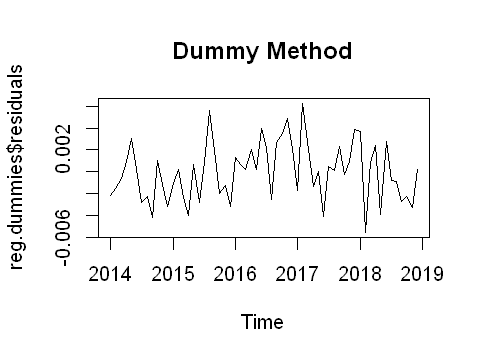

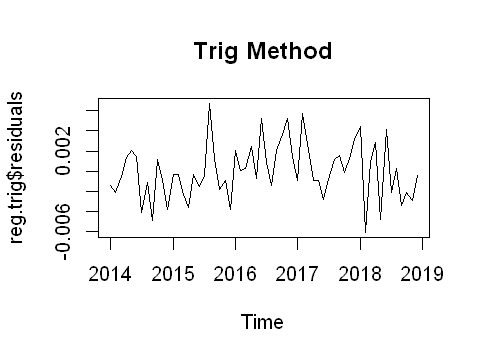

In [6]:
# Check residuals on dummies model
options(repr.plot.width=4, repr.plot.height=3) # adjust plot size
# checkresiduals(arima.dummies) # fancier function to evaluate residuals
plot(reg.dummies$residuals, main = 'Dummy Method')

# Check residuals on trig model
# checkresiduals(arima.trig) # fancier function to evaluate residuals
plot(reg.trig$residuals, main = 'Trig Method')

From looking at the plot, we would need to perform `ADF Test about zero mean or single mean` to test for stationarity in this case. However, R offers ADF test **including trend**, which is not appropriate in this case since there is no trend from the plot.

An alternative approach would be to call `ndiffs()` which determines the number of <u>nonseasonal</u> differences required to make a given time series stationary.

In [7]:
# See if residuals are stationary
ndiffs(reg.dummies$residuals)
ndiffs(reg.trig$residuals)

# Both dummies and trig methods have stationary residuals since 0 differences need to be taken.

[1] 0

[1] 0

After getting stationary series, we can now fit an ARIMA model.

We could look at the ACF and PACF plots to estimate what the AR and MA terms are..... trial-and-error. <br>
Luckily R has `auto.arima()` from the forecast package that finds the best AR and MA terms based on AIC values.
***
We are going to input the **residuals** from the regression models since we have already taken care of seasonality. Using `auto.arima(series)` assumes seasonality has not already been taken care of and the function will take seasonal difference to account for stochastic seasonality. The function cannot handle deterministic seasonality as of currently.

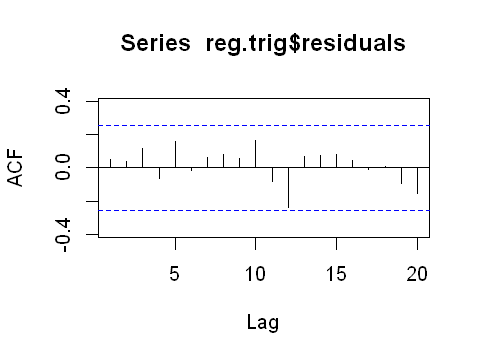

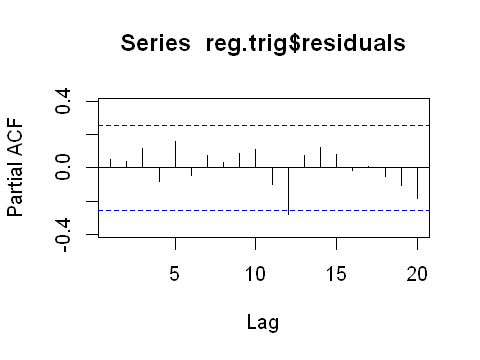

In [8]:
# Code for plotting ACF and PACF plots
options(repr.plot.width=4, repr.plot.height=3)

acf <- Acf(reg.trig$residuals, lag = 20)$acf
pacf <- Pacf(reg.trig$residuals, lag = 20)$acf

In [9]:
dummies_fit <- auto.arima(reg.dummies$residuals)
dummies_fit # 1 nonseasonal AR term, 1 seasonal AR term

trig_fit <- auto.arima(reg.trig$residuals)
trig_fit # 0 nonseasonal terms, 1 seasonal MA term

# The seasonal AR and MA terms deal with correlation structure and not the pattern itself (only took care of pattern so far)
# AR and MA terms deal with correlation not seasonality structure, so you would look at seasonal terms as well

Series: reg.dummies$residuals 
ARIMA(1,0,0)(1,0,0)[12] with zero mean 

Coefficients:
            ar1        sar1
      0.2124521  -0.4085407
s.e.  0.1296734   0.1301577

sigma^2 estimated as 5.829167e-06:  log likelihood=276.34
AIC=-546.68   AICc=-546.25   BIC=-540.4

Series: reg.trig$residuals 
ARIMA(0,0,0)(0,0,1)[12] with zero mean 

Coefficients:
            sma1
      -0.4360628
s.e.   0.1707225

sigma^2 estimated as 6.600981e-06:  log likelihood=271.95
AIC=-539.9   AICc=-539.69   BIC=-535.71

After getting the AR and MA terms for the potential ARIMA models, go ahead and build them with the training data.

In [10]:
# Models with AR and MA terms
arima.dummies <- Arima(trainingTS, order=c(1,0,0), seasonal = c(1,0,0), xreg = reg.ozone)
summary(arima.dummies) # got lower MAE/MAPE values!

arima.trig <- Arima(trainingTS, order=c(0,0,0), seasonal = c(0,0,1), xreg = fourier(trainingTS, K=4))
summary(arima.trig)

Series: trainingTS 
Regression with ARIMA(1,0,0)(1,0,0)[12] errors 

Coefficients:
            ar1        sar1  intercept  month.factor2  month.factor3
      0.2234739  -0.4650153  0.0306585      0.0060452      0.0123397
s.e.  0.1303497   0.1347052  0.0007905      0.0009901      0.0010851
      month.factor4  month.factor5  month.factor6  month.factor7  month.factor8
          0.0163781      0.0157716      0.0180396      0.0160142      0.0141296
s.e.      0.0011082      0.0011120      0.0011134      0.0011151      0.0011146
      month.factor9  month.factor10  month.factor11  month.factor12
          0.0075536       0.0051679       0.0006944      -0.0044607
s.e.      0.0011186       0.0011096       0.0010949       0.0010142

sigma^2 estimated as 7.107816e-06:  log likelihood=276.98
AIC=-523.95   AICc=-513.04   BIC=-492.54

Training set error measures:
                           ME           RMSE            MAE           MPE
Training set -5.911574937e-05 0.002334378998 0.001975663237 -0

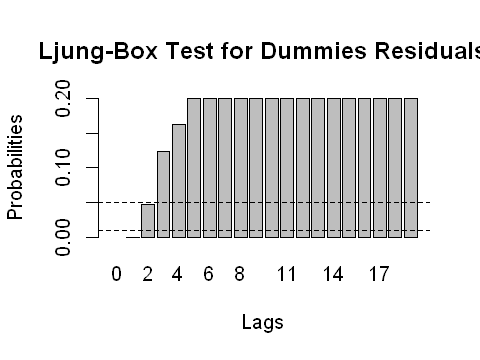

In [11]:
# White Noise for Dummies Model
# Perform Ljung-Box test up to 20 lags on residuals then store p-values in white.LB_resid
# Number of lags observed has increased from HW 3 to capture more seasonality
# fitdf = 2 because 1 nonseasonal and 1 seasonal terms were used

White.LB_resid <- rep(NA, 20)

for(i in 1:20){
  White.LB_resid[i] <- Box.test(arima.dummies$residuals, lag = i, type = "Lj", fitdf = 2)$p.value
}

# p-values >= 0.2 are recorded as 0.2 (for plotting purposes)
White.LB_resid <- pmin(White.LB_resid, 0.2)

# Let's look at a plot of these p-values (lags 1,2,...,10)
# The horizontal lines let us see which lags have p-values <0.05 and <0.01
barplot(White.LB_resid, 
        main = "Ljung-Box Test for Dummies Residuals", 
        ylab = "Probabilities", 
        xlab = "Lags", 
        ylim = c(0, 0.2),
        names.arg = seq(0,19))

abline(h = 0.01, lty = "dashed", col = "black")
abline(h = 0.05, lty = "dashed", col = "black")

# We want all lags to be insignificant and fail to reject OVERALL --> almost all are insignificant
# White noise potentially exists

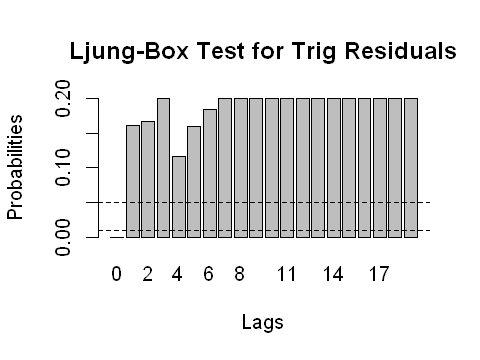

In [12]:
# White Noise for Trig Model
# fitdf = 1 because 1 seasonal term was used

White.LB_resid <- rep(NA, 20)

for(i in 1:20){
  White.LB_resid[i] <- Box.test(arima.trig$residuals, lag = i, type = "Lj", fitdf = 1)$p.value
}

# p-values >= 0.2 are recorded as 0.2 (for plotting purposes)
White.LB_resid <- pmin(White.LB_resid, 0.2)

# Let's look at a plot of these p-values (lags 1,2,...,10)
# The horizontal lines let us see which lags have p-values <0.05 and <0.01
barplot(White.LB_resid, 
        main = "Ljung-Box Test for Trig Residuals", 
        ylab = "Probabilities", 
        xlab = "Lags", 
        ylim = c(0, 0.2),
        names.arg = seq(0,19))

abline(h = 0.01, lty = "dashed", col = "black")
abline(h = 0.05, lty = "dashed", col = "black")

# We want all lags to be insignificant and fail to reject OVERALL --> no autocorrelation of residuals!
# White noise exists

Now that we have potential models built from our training data. We need to forecast on validation data and compare MAE/MAPE values using the dummies and trig arima models. Then we can choose the final model with best MAPE/MAE to be scored with test data.

In [13]:
# Forecast on validation data using Dummies
dummies_pred <- forecast(arima.dummies, xreg = reg.ozone)
dummies_pred_v <- dummies_pred$mean[1:12] # predictions for validation

# Calculate validation data error
dummies_pred_v_error <- validTS - dummies_pred_v
# Validation MAE = 0.00222
MAE_dummies_v <- mean(abs(dummies_pred_v_error))
# Validation MAPE = 5.639
MAPE_dummies_v <- mean(abs(dummies_pred_v_error)/abs(validTS))*100

MAE_dummies_v
MAPE_dummies_v

[1] 0.002224892726

[1] 5.63915575

In [14]:
# Forecast on validation data using Trig
trig_pred <- forecast(arima.trig, xreg = fourier(trainingTS, K=4))
trig_pred_v <- trig_pred$mean[1:12] # predictions for validation

# Calculate validation data error
trig_pred_v_error <- validTS - trig_pred_v
# Dummies validation MAE = 0.00239
MAE_trig_v <- mean(abs(trig_pred_v_error))
# Trig validation MAPE = 5.973
MAPE_trig_v <- mean(abs(trig_pred_v_error)/abs(validTS))*100

MAE_trig_v
MAPE_trig_v

[1] 0.002390431838

[1] 5.972858134

The trig model has better MAE/MAPE values, so we will choose the trig model as our final model to be scored with test data.

In [15]:
# Forecast predictions using Trig model on testing (5 months) 
trig_pred_test <- trig_pred$mean[13:17] # predictions for testing data
# Calculate test data error
trig_pred_test_error <- testTS - trig_pred_test
# Trig test MAE = 0.00374
MAE_trig_test <- mean(abs(trig_pred_test_error))
# Trig test MAPE = 9.78923
MAPE_trig_test <- mean(abs(trig_pred_test_error)/abs(testTS))*100

MAE_trig_test
MAPE_trig_test

[1] 0.003773612174

[1] 9.90904176

### Plot actual vs predicted for validation data

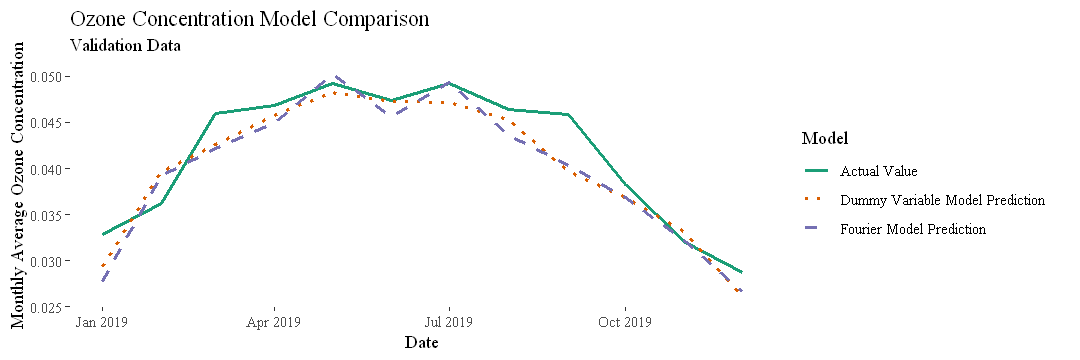

In [16]:
#### Validation Data ####
results_df <- data.frame(trig_pred_v = trig_pred_v,
                         dummies_pred_v = dummies_pred_v,
                         actual = validTS,
                         date = seq(as.Date('2019-01-01'), as.Date('2019-12-01'), by="months"))

options(repr.plot.width=9, repr.plot.height=3)

results_df %>% 
  select(date, actual, trig_pred_v, dummies_pred_v) %>% 
  gather(key = 'Model', value = value, -date) %>% 
  mutate(Model = case_when(Model == 'actual' ~ 'Actual Value',
                           Model == 'dummies_pred_v' ~ 'Dummy Variable Model Prediction',
                           Model == 'trig_pred_v' ~ 'Fourier Model Prediction')) %>% 
  ggplot(aes(x = date, y = value, color = Model)) +
  geom_line(size = 1, aes(linetype = Model)) +
  scale_color_brewer(palette = 'Dark2') +
  scale_linetype_manual(values = c('solid', 'dotted', 'dashed'))+
  theme_tufte()+ 
  labs(x = 'Date', 
       y = 'Monthly Average Ozone Concentration',
       title = 'Ozone Concentration Model Comparison',
       subtitle = 'Validation Data')

### Plot actual vs predicted for test data

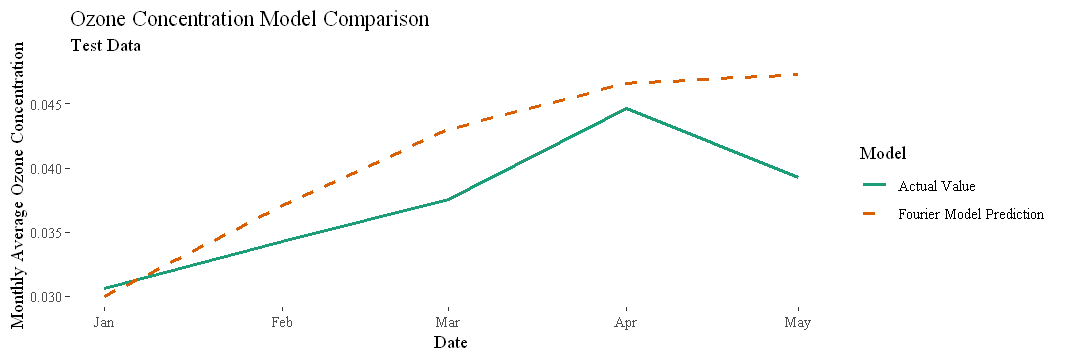

In [17]:
####Color test data ####

# Create df with predicted values, actual values (test data), and date for the 5 month forecast
results_df <- data.frame(trig_pred = trig_pred_test,
                         dummies_pred = dummies_pred$mean[13:17],
                         actual = testTS,
                         date = seq(as.Date('2020-01-01'), as.Date('2020-05-01'), by="months"))
results_df %>% 
  select(date, actual, trig_pred) %>% 
  gather(key = 'Model', value = value, -date) %>% 
  mutate(Model = case_when(Model == 'actual' ~ 'Actual Value',
                           Model == 'dummies_pred' ~ 'Dummy Variable Model Prediction',
                           Model == 'trig_pred' ~ 'Fourier Model Prediction')) %>% 
  ggplot(aes(x = date, y = value, color = Model)) +
  geom_line(size = 1, aes(linetype = Model)) +
  scale_color_brewer(palette = 'Dark2') +
  scale_linetype_manual(values = c('solid', 'dashed'))+
  theme_tufte()+ 
  labs(x = 'Date', 
       y = 'Monthly Average Ozone Concentration',
       title = 'Ozone Concentration Model Comparison',
       subtitle = 'Test Data')